In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Patch Features <a target="_blank" href="https://colab.research.google.com/github/facebookresearch/dinov2/blob/main/notebooks/patch_features.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys

os.environ["XFORMERS_DISABLED"] = "1" # Switch to enable xFormers

INSTALL = True # Switch this to install dependencies
if INSTALL:
    !{sys.executable} -m pip install -U scikit-image scikit-learn ipywidgets

## Fetch and load resources

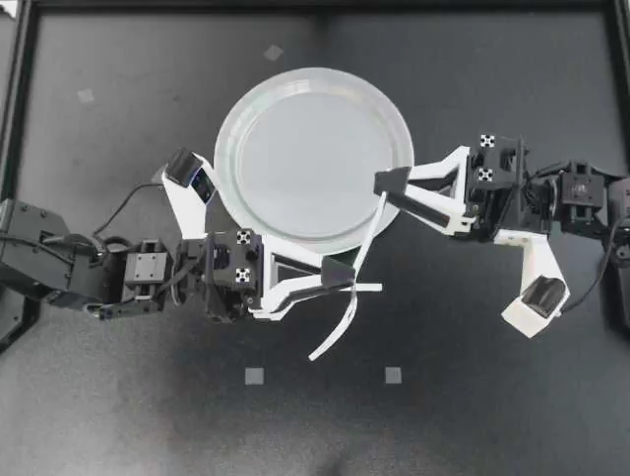

In [2]:
import urllib

import io
import numpy as np
from PIL import Image


def load_array_from_url(url: str) -> np.ndarray:
    with urllib.request.urlopen(url) as f:
        array_data = f.read()
        g = io.BytesIO(array_data)
        return np.load(g)


def load_image_from_url(url: str) -> Image:
    with urllib.request.urlopen(url) as f:
        return Image.open(f).convert("RGB")


def resize_to_nearest_multiple(image, size=14):
    width, height = image.size
    new_width = width - width % size
    new_height = height - height % size
    return image.resize((new_width, new_height))

image = resize_to_nearest_multiple(Image.open("image_400.png"))

def resize_to_nearest_multiple(image, size=14):
    width, height = image.size
    new_width = width - width % size
    new_height = height - height % size
    return image.resize((new_width, new_height))

image = resize_to_nearest_multiple(Image.open("image_400.png"))

# # Precomputed foreground / background projection
# STANDARD_ARRAY_URL = "https://dl.fbaipublicfiles.com/dinov2/arrays/standard.npy"
# standard_array = load_array_from_url(STANDARD_ARRAY_URL)

# EXAMPLE_IMAGE_URL = "https://dl.fbaipublicfiles.com/dinov2/images/example.jpg"
# example_image = load_image_from_url(EXAMPLE_IMAGE_URL)
# display(example_image)
display(image)
example_image = image

## Filter background, compute PCA and visualize projection

In [3]:
torch.cuda.is_available()

NameError: name 'torch' is not defined

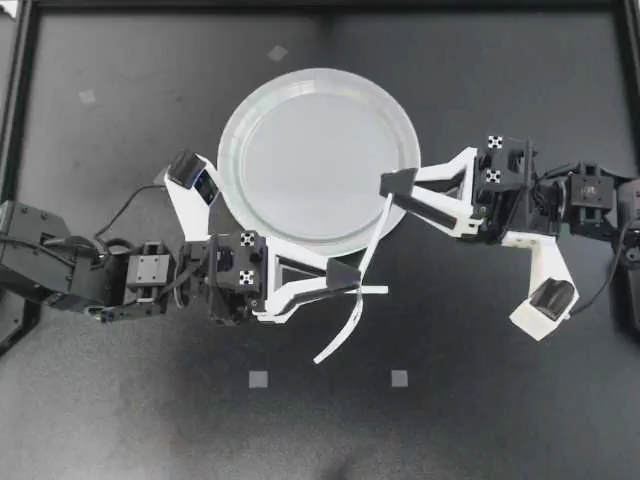

using dinov2_vits14_reg model


Using cache found in /home/weixun/.cache/torch/hub/facebookresearch_dinov2_main


patch size: 14
Image Size:  torch.Size([3, 448, 588])
Tokens:  torch.Size([1344, 384])
t_min:  tensor([[-14.8938, -11.9741, -11.0375, -11.5682, -11.4444,  -8.5966]],
       dtype=torch.float64)
t_max:  tensor([[11.8041, 19.0450, 11.7409, 13.0513, 11.2262, 12.0227]],
       dtype=torch.float64)
Origninal Resolution Size: ( (1344, 6) )


In [5]:
from typing import Tuple

import numpy as np
from PIL import Image
from sklearn.decomposition import PCA
from scipy.ndimage import binary_closing, binary_opening
import torch
import torchvision.transforms as transforms


REPO_NAME = "facebookresearch/dinov2"
MODEL_NAME = "dinov2_vits14_reg"

# Precomputed foreground / background projection
STANDARD_ARRAY_URL = "https://dl.fbaipublicfiles.com/dinov2/arrays/standard.npy"
# standard_array = load_array_from_url(STANDARD_ARRAY_URL)

EXAMPLE_IMAGE_URL = "https://dl.fbaipublicfiles.com/dinov2/images/example.jpg"
# example_image = load_image_from_url(EXAMPLE_IMAGE_URL)
example_image = Image.open("image_400.png")
display(example_image)

DEFAULT_SMALLER_EDGE_SIZE = 448
DEFAULT_BACKGROUND_THRESHOLD = 0.05
NUM_PCA_COMPONENTS = 6
DEFAULT_APPLY_OPENING = False
DEFAULT_APPLY_CLOSING = False


def make_transform(smaller_edge_size: int) -> transforms.Compose:
    IMAGENET_DEFAULT_MEAN = (0.485, 0.456, 0.406)
    IMAGENET_DEFAULT_STD = (0.229, 0.224, 0.225)
    interpolation_mode = transforms.InterpolationMode.BICUBIC

    return transforms.Compose([
        transforms.Resize(size=smaller_edge_size, interpolation=interpolation_mode, antialias=True),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
    ])


def prepare_image(image: Image,
                  smaller_edge_size: float,
                  patch_size: int) -> Tuple[torch.Tensor, Tuple[int, int]]:
    transform = make_transform(int(smaller_edge_size))
    image_tensor = transform(image)

    # Crop image to dimensions that are a multiple of the patch size
    height, width = image_tensor.shape[1:] # C x H x W
    cropped_width, cropped_height = width - width % patch_size, height - height % patch_size
    image_tensor = image_tensor[:, :cropped_height, :cropped_width]

    grid_size = (cropped_height // patch_size, cropped_width // patch_size) # h x w (TODO: check)
    return image_tensor, grid_size


def make_foreground_mask(tokens,
                         grid_size: Tuple[int, int],
                         background_threshold: float = 0.0,
                         apply_opening: bool = True,
                         apply_closing: bool = True):
    projection = tokens @ standard_array
    mask = projection > background_threshold
    mask = mask.reshape(*grid_size)
    if apply_opening:
        mask = binary_opening(mask)
    if apply_closing:
        mask = binary_closing(mask)
    return mask.flatten()


def render_patch_pca(image: Image,
                     smaller_edge_size: float = 448,
                     patch_size: int = 14,
                     background_threshold: float = 0.05,
                     apply_opening: bool = False,
                     apply_closing: bool = False) -> Image:
    image_tensor, grid_size = prepare_image(image, smaller_edge_size, patch_size)
    print("Image Size: ", image_tensor.shape)

    with torch.inference_mode():
        image_batch = image_tensor.unsqueeze(0)
        infered = model.get_intermediate_layers(image_batch)
        # print("Infered shape: ", infered.shape)
        tokens = infered[0].squeeze()
    print("Tokens: ", tokens.shape)


    # mask = make_foreground_mask(tokens,
    #                             grid_size,
    #                             background_threshold,
    #                             apply_opening,
    #                             apply_closing)
    pca = PCA(n_components=NUM_PCA_COMPONENTS)
    pca.fit(tokens)
    projected_tokens = pca.transform(tokens)

    t = torch.tensor(projected_tokens)
    t_min = t.min(dim=0, keepdim=True).values
    t_max = t.max(dim=0, keepdim=True).values
    # normalized_t = (t - t_min) / (t_max - t_min)
    print("t_min: ", t_min)
    print("t_max: ", t_max)

    # array = (t).byte().numpy()
    array = (t).numpy()
    print("Origninal Resolution Size: (", array.shape, ")")
    # array[~mask] = 0
    array = array.reshape(*grid_size, NUM_PCA_COMPONENTS)

    # Create rgb image from top 3 components
    return array, pca.explained_variance_ratio_#, Image.fromarray(array[:, :, :3]).resize((image.width, image.height), 0)



print(f"using {MODEL_NAME} model")
model = torch.hub.load(repo_or_dir=REPO_NAME, model=MODEL_NAME)
model.eval()
print(f"patch size: {model.patch_size}")

arr, explained_variance = render_patch_pca(image=example_image,
                 smaller_edge_size=DEFAULT_SMALLER_EDGE_SIZE,
                 patch_size=model.patch_size,
                 background_threshold=DEFAULT_BACKGROUND_THRESHOLD,
                 apply_opening=DEFAULT_APPLY_OPENING,
                 apply_closing=DEFAULT_APPLY_CLOSING)

In [120]:
448/14, 588/14, 32*42

(32.0, 42.0, 1344)

In [18]:
# Infer entirely vs infer until the last layer
image_tensor, grid_size = prepare_image(example_image, DEFAULT_SMALLER_EDGE_SIZE, patch_size=14)
model.eval().cuda()

with torch.inference_mode():
    image_batch = image_tensor.unsqueeze(0).cuda()
    infered  = model.get_intermediate_layers(image_batch)
    infered =  model.norm(infered[0])
    infered_ = model(image_batch)
    # print("Infered shape: ", infered.shape)
    # tokens = infered[0].squeeze()
    tokens = infered[0].squeeze()
    features = infered_.squeeze()
print("Tokens: ", tokens.shape)
print("Features: ", features.shape)
print("Model: ", model)

Infered shape:  1
Tokens:  torch.Size([1344, 384])
Features:  torch.Size([384])
Model:  DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplac

In [19]:
import torch

# Assuming prepare_image is defined and works correctly.
image_tensor, grid_size = prepare_image(example_image, DEFAULT_SMALLER_EDGE_SIZE, patch_size=14)

# Ensure the model is in evaluation mode and moved to GPU.
model.eval().cuda()

with torch.inference_mode():
    image_batch = image_tensor.unsqueeze(0).cuda()

    # Obtain the intermediate layers' output. Let's take the last 3 layers for example.
    intermediate_outputs = model.get_intermediate_layers(image_batch, n=3, norm=True, return_class_token=True)

    # Separate the outputs into patch tokens and class tokens.
    patch_tokens, class_tokens = zip(*intermediate_outputs)

    # Direct forward pass of the model for comparison.
    final_output = model(image_batch).squeeze()

# Print shapes of the tokens and features.
for i, (patch_tok, class_tok) in enumerate(zip(patch_tokens, class_tokens)):
    print(f"Intermediate layer {i + 1}:")
    print(f"  Patch Tokens shape: {patch_tok.shape}")
    print(f"  Class Token shape: {class_tok.shape}")

print("Features (final model output): ", final_output.shape)
print("Model: ", model)

Intermediate layer 1:
  Patch Tokens shape: torch.Size([1, 1344, 384])
  Class Token shape: torch.Size([1, 384])
Intermediate layer 2:
  Patch Tokens shape: torch.Size([1, 1344, 384])
  Class Token shape: torch.Size([1, 384])
Intermediate layer 3:
  Patch Tokens shape: torch.Size([1, 1344, 384])
  Class Token shape: torch.Size([1, 384])
Features (final model output):  torch.Size([384])
Model:  DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Iden

In [22]:
import torch

# Assuming prepare_image is defined and works correctly.
image_tensor, grid_size = prepare_image(example_image, DEFAULT_SMALLER_EDGE_SIZE, patch_size=14)

# Ensure the model is in evaluation mode and moved to GPU.
model.eval().cuda()

with torch.inference_mode():
    image_batch = image_tensor.unsqueeze(0).cuda()
    
    # Step 1: Prepare the tokens
    tokens = model.prepare_tokens_with_masks(image_batch)
    
    # Step 2: Run through all but the last layer
    for i, blk in enumerate(model.blocks[:-1]):  # Skip the last block
        tokens = blk(tokens)
    
    # Step 3: Extract the output of the last intermediate layer
    last_intermediate_output = tokens
    
    # Step 4: Continue the forward pass from the last intermediate layer
    last_block = model.blocks[-1]
    final_tokens = last_block(last_intermediate_output)
    
    # Apply final normalization
    normalized_final_tokens = model.norm(final_tokens)
    
    # The final output is typically taken from the class token
    final_output = model.head(normalized_final_tokens[:, 0])

    # Original forward pass for comparison
    final_output_original = model(image_batch).squeeze()

# Print shapes of the intermediate and final tokens.
print("Last Intermediate Layer Output shape: ", last_intermediate_output.shape)
print("Final Tokens shape: ", final_tokens.shape) # 1349 = 1344 + 4 registers + 1 cls token
print("Normalized Final Tokens shape: ", normalized_final_tokens.shape)
print("Final Output shape: ", final_output.shape)
print("final_output_original shape: ", final_output_original.shape)
# Check if the final output is the same as the original forward pass.
print(torch.allclose(final_output, final_output_original))
print("Model: ", model)

Last Intermediate Layer Output shape:  torch.Size([1, 1349, 384])
Final Tokens shape:  torch.Size([1, 1349, 384])
Normalized Final Tokens shape:  torch.Size([1, 1349, 384])
Final Output shape:  torch.Size([1, 384])
final_output_original shape:  torch.Size([384])
True
Model:  DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_fe

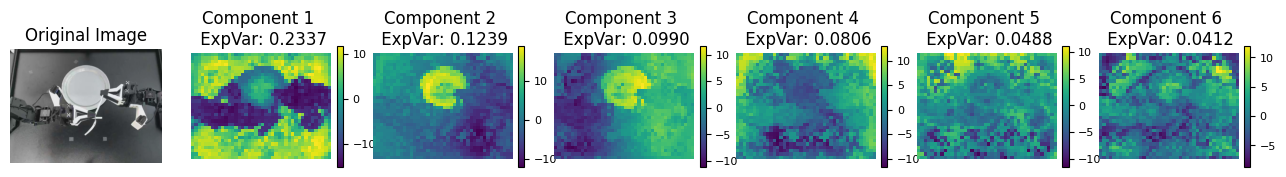

In [7]:
from matplotlib import pyplot as plt

# Plotting the images with colorbars
plt.figure(figsize=(16, 2))  # Adjust figsize as needed

# Plot the original PCA image
plt.subplot(1, NUM_PCA_COMPONENTS + 1, 1)
plt.imshow(example_image)
plt.title("Original Image")
plt.axis('off')

# Plot each PCA component with a colorbar
for i in range(NUM_PCA_COMPONENTS):
    plt.subplot(1, NUM_PCA_COMPONENTS + 1, i + 2)
    im = plt.imshow(arr[:, :, i], cmap='viridis')
    plt.title(f"Component {i+1} \n ExpVar: {explained_variance[i]:.4f}")
    plt.axis('off')
    cbar = plt.colorbar(im, orientation='vertical', fraction=0.04, pad=0.04)
    cbar.ax.tick_params(labelsize=8)
        # plt.colorbar(im, orientation='vertical', fraction=0.046, pad=0.04)

# plt.tight_layout()
plt.show()
# Dino v2 has learned features that first captures the background


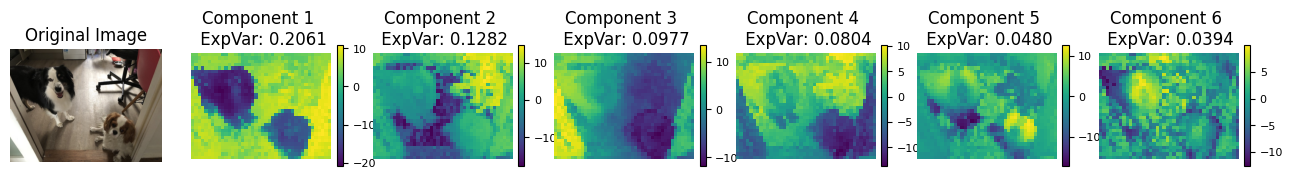

In [115]:
# Plotting the images with colorbars
plt.figure(figsize=(16, 2))  # Adjust figsize as needed

# Plot the original PCA image
plt.subplot(1, NUM_PCA_COMPONENTS + 1, 1)
plt.imshow(example_image)
plt.title("Original Image")
plt.axis('off')

# Plot each PCA component with a colorbar
for i in range(NUM_PCA_COMPONENTS):
    plt.subplot(1, NUM_PCA_COMPONENTS + 1, i + 2)
    im = plt.imshow(arr[:, :, i], cmap='viridis')
    plt.title(f"Component {i+1} \n ExpVar: {explained_variance[i]:.4f}")
    plt.axis('off')
    cbar = plt.colorbar(im, orientation='vertical', fraction=0.04, pad=0.04)
    cbar.ax.tick_params(labelsize=8)
        # plt.colorbar(im, orientation='vertical', fraction=0.046, pad=0.04)

# plt.tight_layout()
plt.show()
# Dino v2 has learned features that first captures the background


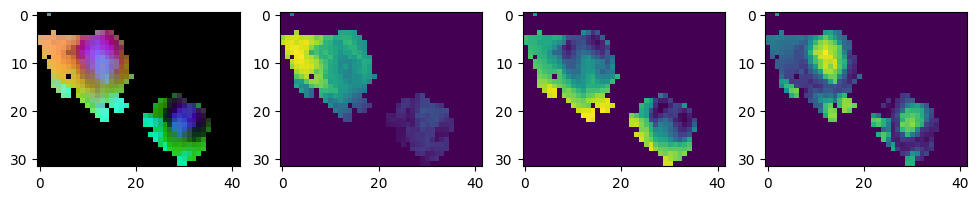

In [54]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 4, 1)
plt.imshow(arr)
plt.subplot(1, 4, 2)
plt.imshow(arr[ :, :, 0])
plt.subplot(1, 4, 3)
plt.imshow(arr[ :, :, 1])
plt.subplot(1, 4, 4)
plt.imshow(arr[ :, :, 2])
plt.show()

## Simple controls to explore the PCA of patch features

In [7]:
if INSTALL: # Try installing package
    !{sys.executable} -m pip install -U ipywidgets


import ipywidgets as widgets


def get_image(image_data: bytes) -> Image:
    with io.BytesIO(image_data) as f:
        return Image.open(f).convert("RGB")


def get_image_data(image: Image) -> bytes:
    with io.BytesIO() as f:
        image.save(f, format="PNG")
        return f.getvalue()


def make_blank_image(size: Tuple[int, int]) -> Image:
    return Image.new(mode="RGBA", size=size, color=(0, 0, 0, 0))


blank_result = make_blank_image(size=example_image.size)

DEFAULT_IMAGE_DATA = get_image_data(example_image)
DEFAULT_RESULT_DATA = get_image_data(blank_result)

image_widget = widgets.Image(
    value=DEFAULT_IMAGE_DATA,
    width=512,
    height=384,
)
upload_widget = widgets.FileUpload(
    accept="image/*",
    multiple=False,
)
smaller_edge_size_widget = widgets.IntSlider(
    value=DEFAULT_SMALLER_EDGE_SIZE,
    min=84,
    max=1344,
    step=1,
    description="Image size (smaller edge):",
    disabled=False,
    continuous_update=False,
    orientation="horizontal",
    readout=True,
    readout_format="d",
    style={"description_width": "initial"},
    layout=widgets.Layout(width="50%"),
)
background_threshold_widget = widgets.FloatSlider(
    value=DEFAULT_BACKGROUND_THRESHOLD,
    min=-1.0,
    max=1.0,
    step=0.01,
    description="Background threshold:",
    disabled=False,
    continuous_update=False,
    orientation="horizontal",
    readout=True,
    readout_format="0.02f",
    style={"description_width": "initial"},
    layout=widgets.Layout(width="50%"),
)
apply_opening_widget = widgets.Checkbox(
    value=DEFAULT_APPLY_OPENING,
    description="Apply opening operation",
    indent=False,
)
apply_closing_widget = widgets.Checkbox(
    value=DEFAULT_APPLY_CLOSING,
    description="Apply closing operation",
    indent=False,
)
clear_widget = widgets.Button(
    description="Clear",
    disabled=False,
    button_style="",
    tooltip="Click to reset inputs",
    icon="",
)
submit_widget = widgets.Button(
    description="Submit",
    disabled=False,
    button_style="success",
    tooltip="Click to run with specified inputs",
    icon="check",
)
result_widget = widgets.Image(
    value=DEFAULT_RESULT_DATA,
    width=512,
    height=384,
)

image_hbox = widgets.HBox([image_widget, result_widget])
button_hbox = widgets.HBox([upload_widget, clear_widget, submit_widget])
settings_vbox = widgets.VBox([
    smaller_edge_size_widget,
    background_threshold_widget,
    apply_opening_widget,
    apply_closing_widget,
])

box_widget = widgets.VBox(children=[
    image_hbox,
    settings_vbox,
    button_hbox,
])


def upload_callback(widget):
    print("Updating image")

    image_data = upload_widget.value[0]["content"]
    image_widget.value = image_data

    image = get_image(image_data)
    blank_image = make_blank_image(image.size)
    result_data = get_image_data(blank_image)
    result_widget.value = result_data


def clear_callback(widget):
    print("Resetting inputs")

    image_widget.value = DEFAULT_IMAGE_DATA
    smaller_edge_size_widget.value = DEFAULT_SMALLER_EDGE_SIZE
    background_threshold_widget.value = DEFAULT_BACKGROUND_THRESHOLD
    apply_opening_widget.value = DEFAULT_APPLY_OPENING
    apply_closing_widget.value = DEFAULT_APPLY_CLOSING
    result_widget.value = DEFAULT_RESULT_DATA


def submit_callback(widget):
    print("Rendering PCA")

    image = get_image(image_widget.value)
    print(image.size)
    result = render_patch_pca(image=image,
                              smaller_edge_size= smaller_edge_size_widget.value ,
                              patch_size=model.patch_size,
                              background_threshold=background_threshold_widget.value,
                              apply_opening=apply_opening_widget.value,
                              apply_closing=apply_closing_widget.value)
    result_data = get_image_data(result)
    result_widget.value = result_data


upload_widget.observe(upload_callback, names="value")
clear_widget.on_click(clear_callback)
submit_widget.on_click(submit_callback)

display(box_widget)

In [16]:
import time
from PIL import Image
from torchvision import transforms

def resize_to_nearest_multiple(image, size=14, mode=transforms.InterpolationMode.BILINEAR):
    width, height = image.size
    new_width = width - width % size
    new_height = height - height % size
    return transforms.Resize(size=(new_width, new_height), interpolation=mode, antialias=False)

# image = resize_to_nearest_multiple(Image.open("image_400.png"))

# Load your image
img = Image.open('image_400.png')

# Define different interpolation modes
interpolation_modes = [
    transforms.InterpolationMode.NEAREST,
    transforms.InterpolationMode.BILINEAR,
    transforms.InterpolationMode.BICUBIC,
    transforms.InterpolationMode.NEAREST_EXACT
]

# Resize and measure time for each mode
for mode in interpolation_modes:
    resize_transform = resize_to_nearest_multiple(img, mode=mode)
    start_time = time.time()
    resized_img = resize_transform(img)
    end_time = time.time()
    print(f"Resizing with {mode.name} interpolation took {end_time - start_time:.6f} seconds")


Resizing with NEAREST interpolation took 0.004456 seconds
Resizing with BILINEAR interpolation took 0.003322 seconds
Resizing with BICUBIC interpolation took 0.003038 seconds
Resizing with NEAREST_EXACT interpolation took 0.000210 seconds


/home/weixun/anaconda3/envs/aloha_10/lib/python3.10/site-packages/torchvision/transforms/functional.py:466: UserWarning: Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.
  warnings.warn("Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.")


630 476
Resizing with NEAREST interpolation took 4.594088 milliseconds
630 476
Resizing with BILINEAR interpolation took 2.235413 milliseconds
630 476
Resizing with BICUBIC interpolation took 3.324986 milliseconds
630 476
Resizing with NEAREST_EXACT interpolation took 0.221729 milliseconds


/home/weixun/anaconda3/envs/aloha_10/lib/python3.10/site-packages/torchvision/transforms/functional.py:466: UserWarning: Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.
  warnings.warn("Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.")


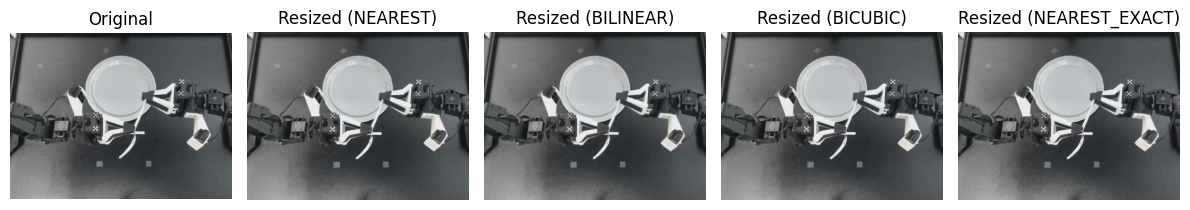

In [24]:
import time
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

def resize_to_nearest_multiple(image, size=14, mode=transforms.InterpolationMode.BILINEAR):
    width, height = image.size
    new_width = width - width % size
    new_height = height - height % size
    print(new_width, new_height)
    return transforms.Resize(size=(new_height, new_width), interpolation=mode, antialias=False)

# Load your image
img = Image.open('image_400.png')

# Define different interpolation modes
interpolation_modes = [
    transforms.InterpolationMode.NEAREST,
    transforms.InterpolationMode.BILINEAR,
    transforms.InterpolationMode.BICUBIC,
    transforms.InterpolationMode.NEAREST_EXACT
]

# Resize and measure time for each mode, storing results
resized_images = []
times = []

for mode in interpolation_modes:
    resize_transform = resize_to_nearest_multiple(img, mode=mode)
    start_time = time.time()
    resized_img = resize_transform(img)
    end_time = time.time()
    times.append(end_time - start_time)
    resized_images.append((mode.name, resized_img))
    print(f"Resizing with {mode.name} interpolation took {((end_time - start_time) * 1000):.6f} milliseconds")

# Plot the original and resized images side by side
plt.figure(figsize=(12, 8))
plt.subplot(1, len(interpolation_modes) + 1, 1)
plt.imshow(img)
plt.title('Original')
plt.axis('off')

for i, (mode_name, resized_img) in enumerate(resized_images):
    plt.subplot(1, len(interpolation_modes) + 1, i + 2)
    plt.imshow(resized_img)
    plt.title(f'Resized ({mode_name})')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [116]:
print(model)

DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n